In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
!pip install catboost
!pip install optuna
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
import numpy as np
import pandas as pd

import sklearn
import sklearn.metrics
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, precision_score, recall_score, f1_score, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from math import sqrt
from scipy import stats as st
from random import randrange
from matplotlib import pyplot

import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.ensemble import RandomForestClassifier

import optuna
from optuna.samplers import TPESampler

import shap

# Preparing Data

In [25]:
#Open csv file.

data = pd.read_csv('/content/drive/MyDrive/NTDB-Epidural/final_data.csv', index_col = 0)

In [26]:
#Drop patients with unknown outcome of interest.

before = data.shape[0]
data = data[data['Total Length of Stay'].notna()]
after = data.shape[0]

excluded = before - after
print('Number of patients before exclusion: ', before)
print('Number of patients after exclusion: ', after)
print('Number of patients excluded with this criteria: ', excluded)

Number of patients before exclusion:  4790
Number of patients after exclusion:  4764
Number of patients excluded with this criteria:  26


In [27]:
#Exclude.

before = data.shape[0]
data = data[(data['Discharge Disposition'] != 'Deceased/Expired')]
data = data[(data['Discharge Disposition'] != 'Left against medical advice or discontinued care')]
after = data.shape[0]
excluded = before - after

print('Number of patients before exclusion: ', before)
print('Number of patients after exclusion: ', after)
print('Number of patients excluded with this criteria: ', excluded)

Number of patients before exclusion:  4764
Number of patients after exclusion:  4527
Number of patients excluded with this criteria:  237


In [28]:
#Define outcome of interest.

print(data['Total Length of Stay'].quantile(0.80), '\n')

data.loc[data['Total Length of Stay'] <= data['Total Length of Stay'].quantile(0.80), 'OUTCOME'] = 0
data.loc[data['Total Length of Stay'] > data['Total Length of Stay'].quantile(0.80), 'OUTCOME'] = 1

data['OUTCOME'].value_counts(normalize=False, dropna=False)

7.0 



0.0    3721
1.0     806
Name: OUTCOME, dtype: int64

In [29]:
#Define predictor variables (x) and outcome of interest (y).

outcomes = ['Total Length of Stay', 'Discharge Disposition', 'Hospital Complication - Cardiac Arrest with CPR', 'Hospital Complication - Catheter-Associated Urinary Tract Infection (CAUTI)', 'Hospital Complication - Central Line-Associated Bloodstream Infection (CLABSI)', 'Hospital Complication - Catheter-Related Blood Stream Infection', 'Hospital Complication - Deep Surgical Site Infection', 'Hospital Complication - Delirium', 'Hospital Complication - Alcohol Withdrawal Syndrome', 'Hospital Complication - Deep Vein Thrombosis (DVT)', 'Hospital Complication - Pulmonary Embolism', 'Hospital Complication - Extremity Compartment Syndrome', 'Hospital Complication - Graft or Prosthesis or Flap Failure', 'Hospital Complication - Unplanned Intubation', 'Hospital Complication - Acute Kidney Injury', 'Hospital Complication - Myocardial Infarction', 'Hospital Complication - Organ or Space Surgical Site Infection', 'Hospital Complication - Osteomyelitis', 'Hospital Complication - Pneumonia', 'Hospital Complication - Pressure or Decubitis Ulcer', 'Hospital Complication - Acute Respiratory Distress Syndrome (ARDS)', 'Hospital Complication - Unplanned Return to the OR', 'Hospital Complication - Severe Sepsis', 'Hospital Complication - Stroke  or  CVA', 'Hospital Complication - Superficial Surgical Site Infection', 'Hospital Complication - Unplanned Admission to the ICU', 'Hospital Complication - Urinary Tract Infection', 'Hospital Complication - Ventilator-Associated Pneumonia (VAP)', 'Total ICU Length of Stay', 'OUTCOME']

x = data.drop(outcomes, axis = 1)
y = data['OUTCOME']

In [30]:
#Check data shapes.

print(y.shape)
print(x.shape)

(4527,)
(4527, 249)


In [31]:
#Split data into initial train set and test set in 80:20 ratio.

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
  
#Describe initial train set and test set.

print("Number patients x_train dataset: ", x_train.shape[0])
print("Number patients y_train dataset: ", y_train.shape[0])
print("Number patients x_test dataset: ", x_test.shape[0])
print("Number patients y_test dataset: ", y_test.shape[0])

Number patients x_train dataset:  3621
Number patients y_train dataset:  3621
Number patients x_test dataset:  906
Number patients y_test dataset:  906


In [32]:
#Split initial train set into final train set and validation set in 75:25 ratio.

train_x, valid_x, train_y, valid_y = train_test_split(x_train, y_train, test_size = 0.25, random_state = 0)
  
#Describe train and validation sets.

print("Number patients train_x dataset: ", train_x.shape[0])
print("Number patients train_y dataset: ", train_y.shape[0])
print("Number patients valid_x dataset: ", valid_x.shape[0])
print("Number patients valid_y dataset: ", valid_y.shape[0])

Number patients train_x dataset:  2715
Number patients train_y dataset:  2715
Number patients valid_x dataset:  906
Number patients valid_y dataset:  906


In [33]:
#Describe outcome of interest before resampling.

print("Before resampling, counts of label '1': {}".format(sum(train_y == 1)))
print("Before resampling, counts of label '0': {} \n".format(sum(train_y == 0)))

Before resampling, counts of label '1': 480
Before resampling, counts of label '0': 2235 



In [34]:
#Apply SMOTE.

from imblearn.over_sampling import SMOTE

resampler = SMOTE(random_state = 0)
train_x, train_y = resampler.fit_resample(train_x, train_y)

In [35]:
#Describe outcome of interest after resampling.

print("After resampling, counts of label '1': {}".format(sum(train_y == 1)))
print("After resampling, counts of label '0': {} \n".format(sum(train_y == 0)))

After resampling, counts of label '1': 2235
After resampling, counts of label '0': 2235 



In [36]:
def roc_auc_ci(y_test, y_probs, positive=1):
    AUC = roc_auc_score(y_test, y_probs)
    N1 = sum(y_test == positive)
    N2 = sum(y_test != positive)
    Q1 = AUC / (2 - AUC)
    Q2 = 2*AUC**2 / (1 + AUC)
    SE_AUC = sqrt((AUC*(1 - AUC) + (N1 - 1)*(Q1 - AUC**2) + (N2 - 1)*(Q2 - AUC**2)) / (N1*N2))
    lower = AUC - 1.96*SE_AUC
    upper = AUC + 1.96*SE_AUC
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    return (lower, upper)

# XGBoost

In [37]:
#Hyperparameter tuning for XGBoost.

def objective(trial):

    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "seed": 31,
        "verbosity": 0,
        "objective":  trial.suggest_categorical("objective", ["binary:logistic"]),
        "eval_metric": "auc",
        "booster": trial.suggest_categorical("booster", ["gbtree"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "max_depth" : trial.suggest_int("max_depth", 1, 9),
        "eta" : trial.suggest_float("eta", 1e-8, 1.0, log=True),
        "gamma" : trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "grow_policy" : trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    }


    # Add a callback for pruning.
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
    
    bst = xgb.train(param, dtrain, evals=[(dvalid, "validation")], callbacks=[pruning_callback])
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_labels)

    return auc


if __name__ == "__main__":
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize", sampler = TPESampler(seed=31)
    )
    study.optimize(objective, n_trials=100)
    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    xgb_params = {}
    
    for key, value in trial.params.items():
        xgb_params[key] = value

[I 2023-01-23 03:18:04,891] A new study created in memory with name: no-name-23e4dcf2-fb18-4dea-9cd0-83cf9bc3671a


[0]	validation-auc:0.700431
[1]	validation-auc:0.736521
[2]	validation-auc:0.729541
[3]	validation-auc:0.735866
[4]	validation-auc:0.738845
[5]	validation-auc:0.739367
[6]	validation-auc:0.734258
[7]	validation-auc:0.742465
[8]	validation-auc:0.738426
[9]	validation-auc:0.744271


[I 2023-01-23 03:18:06,014] Trial 0 finished with value: 0.619538959801867 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.9428110874325094e-06, 'alpha': 0.4622155288125666, 'max_depth': 7, 'eta': 0.7851633597929335, 'gamma': 4.627257790053709e-07, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.619538959801867.


[0]	validation-auc:0.511743
[1]	validation-auc:0.659207
[2]	validation-auc:0.672326
[3]	validation-auc:0.690848
[4]	validation-auc:0.672052
[5]	validation-auc:0.66746
[6]	validation-auc:0.666721
[7]	validation-auc:0.669819
[8]	validation-auc:0.68394
[9]	validation-auc:0.689423


[I 2023-01-23 03:18:06,512] Trial 1 finished with value: 0.6569365593446371 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 3.540855010579091e-08, 'alpha': 4.005546508605542e-08, 'max_depth': 5, 'eta': 5.190362998186933e-08, 'gamma': 1.1458984717217304e-05, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.6569365593446371.


[0]	validation-auc:0.5
[1]	validation-auc:0.513126
[2]	validation-auc:0.659756
[3]	validation-auc:0.690543
[4]	validation-auc:0.670532
[5]	validation-auc:0.67105
[6]	validation-auc:0.683787
[7]	validation-auc:0.684005
[8]	validation-auc:0.670791
[9]	validation-auc:0.674913


[I 2023-01-23 03:18:09,255] Trial 2 finished with value: 0.6569365593446371 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.2472451918309905e-08, 'alpha': 3.5833391127860344e-07, 'max_depth': 5, 'eta': 3.166549087607022e-08, 'gamma': 2.4018078289549153e-06, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.6569365593446371.


[0]	validation-auc:0.668009
[1]	validation-auc:0.671435
[2]	validation-auc:0.676533
[3]	validation-auc:0.675584
[4]	validation-auc:0.679341
[5]	validation-auc:0.681071
[6]	validation-auc:0.680046
[7]	validation-auc:0.683159
[8]	validation-auc:0.683566
[9]	validation-auc:0.682881


[I 2023-01-23 03:18:12,674] Trial 3 finished with value: 0.6175271480281959 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.3853144759016545e-06, 'alpha': 1.810306176116705e-05, 'max_depth': 8, 'eta': 0.00011313716853812925, 'gamma': 1.431538552328043e-06, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.6569365593446371.


[0]	validation-auc:0.697763
[1]	validation-auc:0.702869
[2]	validation-auc:0.706051
[3]	validation-auc:0.70663
[4]	validation-auc:0.705658
[5]	validation-auc:0.70487
[6]	validation-auc:0.706131
[7]	validation-auc:0.706771
[8]	validation-auc:0.705151
[9]	validation-auc:0.705159


[I 2023-01-23 03:18:16,181] Trial 4 finished with value: 0.6340864926652696 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.981512489677599e-07, 'alpha': 8.673160455297617e-07, 'max_depth': 7, 'eta': 1.1789142339699406e-05, 'gamma': 4.915182221710387e-05, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.6569365593446371.


[0]	validation-auc:0.5
[1]	validation-auc:0.655561
[2]	validation-auc:0.655561
[3]	validation-auc:0.655561
[4]	validation-auc:0.655561


[I 2023-01-23 03:18:16,765] Trial 5 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.68695
[1]	validation-auc:0.712562
[2]	validation-auc:0.711423
[3]	validation-auc:0.725475
[4]	validation-auc:0.725788
[5]	validation-auc:0.727632
[6]	validation-auc:0.73433
[7]	validation-auc:0.734879
[8]	validation-auc:0.745277
[9]	validation-auc:0.747403


[I 2023-01-23 03:18:19,068] Trial 6 finished with value: 0.6555000952562392 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.04528142691329445, 'alpha': 0.010014797160429703, 'max_depth': 5, 'eta': 0.08681503874329109, 'gamma': 1.7151544620195505e-06, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.6569365593446371.


[0]	validation-auc:0.5
[1]	validation-auc:0.5
[2]	validation-auc:0.5
[3]	validation-auc:0.5
[4]	validation-auc:0.5


[I 2023-01-23 03:18:20,175] Trial 7 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.69787
[1]	validation-auc:0.702801
[2]	validation-auc:0.706173
[3]	validation-auc:0.706801
[4]	validation-auc:0.704949
[5]	validation-auc:0.70487
[6]	validation-auc:0.706161
[7]	validation-auc:0.706496
[8]	validation-auc:0.705151
[9]	validation-auc:0.705022


[I 2023-01-23 03:18:23,335] Trial 8 finished with value: 0.6340864926652696 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.012396727001275e-07, 'alpha': 4.813416353568083e-07, 'max_depth': 7, 'eta': 7.282914217164152e-06, 'gamma': 1.2485590633659993e-05, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.6569365593446371.


[0]	validation-auc:0.691835
[1]	validation-auc:0.691835
[2]	validation-auc:0.691835
[3]	validation-auc:0.691835
[4]	validation-auc:0.691835


[I 2023-01-23 03:18:24,854] Trial 9 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.674311
[1]	validation-auc:0.674311
[2]	validation-auc:0.674311
[3]	validation-auc:0.674311
[4]	validation-auc:0.674311


[I 2023-01-23 03:18:26,164] Trial 10 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.5
[1]	validation-auc:0.5
[2]	validation-auc:0.5
[3]	validation-auc:0.511743
[4]	validation-auc:0.513126


[I 2023-01-23 03:18:28,739] Trial 11 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.67646
[1]	validation-auc:0.679672
[2]	validation-auc:0.692174
[3]	validation-auc:0.692345
[4]	validation-auc:0.692395


[I 2023-01-23 03:18:30,284] Trial 12 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.666653
[1]	validation-auc:0.649712
[2]	validation-auc:0.651812
[3]	validation-auc:0.652837
[4]	validation-auc:0.654224


[I 2023-01-23 03:18:33,103] Trial 13 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.621463
[1]	validation-auc:0.705167
[2]	validation-auc:0.693873
[3]	validation-auc:0.677546
[4]	validation-auc:0.705338
[5]	validation-auc:0.710741
[6]	validation-auc:0.69912
[7]	validation-auc:0.706336
[8]	validation-auc:0.708322
[9]	validation-auc:0.708859


[I 2023-01-23 03:18:34,153] Trial 14 finished with value: 0.6244275100019052 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.0186944508965197e-05, 'alpha': 1.0485467915378535e-07, 'max_depth': 6, 'eta': 9.19677856890137e-08, 'gamma': 4.494160422789932e-06, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.6569365593446371.


[0]	validation-auc:0.5
[1]	validation-auc:0.5
[2]	validation-auc:0.5
[3]	validation-auc:0.5
[4]	validation-auc:0.502073


[I 2023-01-23 03:18:34,450] Trial 15 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.705693
[1]	validation-auc:0.703532
[2]	validation-auc:0.711255
[3]	validation-auc:0.709869
[4]	validation-auc:0.710966
[5]	validation-auc:0.709945
[6]	validation-auc:0.710619
[7]	validation-auc:0.709834
[8]	validation-auc:0.710913
[9]	validation-auc:0.709636


[I 2023-01-23 03:18:35,008] Trial 16 finished with value: 0.6244236997523338 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.7597392447532736, 'alpha': 3.3763550933105066e-06, 'max_depth': 6, 'eta': 3.079186719646773e-06, 'gamma': 3.2576825079489404e-07, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.6569365593446371.


[0]	validation-auc:0.67989
[1]	validation-auc:0.681718
[2]	validation-auc:0.66967
[3]	validation-auc:0.682263
[4]	validation-auc:0.679135


[I 2023-01-23 03:18:35,273] Trial 17 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.662682
[1]	validation-auc:0.685361
[2]	validation-auc:0.674776
[3]	validation-auc:0.689594
[4]	validation-auc:0.695588


[I 2023-01-23 03:18:35,601] Trial 18 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.707297
[1]	validation-auc:0.708238
[2]	validation-auc:0.70567
[3]	validation-auc:0.705635
[4]	validation-auc:0.704946
[5]	validation-auc:0.702461
[6]	validation-auc:0.70538
[7]	validation-auc:0.70477
[8]	validation-auc:0.705555
[9]	validation-auc:0.704401


[I 2023-01-23 03:18:36,158] Trial 19 finished with value: 0.6244275100019052 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.5191161069080307e-06, 'alpha': 0.00013579366601142545, 'max_depth': 6, 'eta': 2.298055094262618e-06, 'gamma': 0.00017345370979859472, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.6569365593446371.


[0]	validation-auc:0.680644
[1]	validation-auc:0.680644
[2]	validation-auc:0.680644
[3]	validation-auc:0.680644
[4]	validation-auc:0.680644


[I 2023-01-23 03:18:36,444] Trial 20 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.68695
[1]	validation-auc:0.685136
[2]	validation-auc:0.687361
[3]	validation-auc:0.68514
[4]	validation-auc:0.684961


[I 2023-01-23 03:18:36,767] Trial 21 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.68695
[1]	validation-auc:0.685136
[2]	validation-auc:0.687361
[3]	validation-auc:0.68583
[4]	validation-auc:0.688055


[I 2023-01-23 03:18:37,103] Trial 22 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.705609
[1]	validation-auc:0.708581
[2]	validation-auc:0.705601
[3]	validation-auc:0.710703
[4]	validation-auc:0.71132
[5]	validation-auc:0.703532
[6]	validation-auc:0.704751
[7]	validation-auc:0.705228
[8]	validation-auc:0.711766
[9]	validation-auc:0.703784


[I 2023-01-23 03:18:37,698] Trial 23 finished with value: 0.6244275100019052 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 9.84500814854322e-06, 'alpha': 1.086775351711768e-08, 'max_depth': 6, 'eta': 8.072226872360573e-07, 'gamma': 1.0473113051558178e-06, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.6569365593446371.


[0]	validation-auc:0.502073
[1]	validation-auc:0.695984
[2]	validation-auc:0.66762
[3]	validation-auc:0.687247
[4]	validation-auc:0.68104


[I 2023-01-23 03:18:38,006] Trial 24 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.691835
[1]	validation-auc:0.707319
[2]	validation-auc:0.737996
[3]	validation-auc:0.744805
[4]	validation-auc:0.741909
[5]	validation-auc:0.752098
[6]	validation-auc:0.762972
[7]	validation-auc:0.756426
[8]	validation-auc:0.762888
[9]	validation-auc:0.761059


[I 2023-01-23 03:18:38,448] Trial 25 finished with value: 0.6305810630596304 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 7.681679277346457e-08, 'alpha': 0.037809829455709966, 'max_depth': 4, 'eta': 0.5680915069426943, 'gamma': 3.7391325233183334e-07, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.6569365593446371.


[0]	validation-auc:0.70136
[1]	validation-auc:0.701947
[2]	validation-auc:0.705974
[3]	validation-auc:0.704706
[4]	validation-auc:0.705319
[5]	validation-auc:0.702484
[6]	validation-auc:0.705365


[I 2023-01-23 03:18:38,916] Trial 26 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.69401
[1]	validation-auc:0.691587
[2]	validation-auc:0.686866
[3]	validation-auc:0.684988
[4]	validation-auc:0.684972


[I 2023-01-23 03:18:39,241] Trial 27 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.674311
[1]	validation-auc:0.674311
[2]	validation-auc:0.696266
[3]	validation-auc:0.710086
[4]	validation-auc:0.710246
[5]	validation-auc:0.71531
[6]	validation-auc:0.711625
[7]	validation-auc:0.717607
[8]	validation-auc:0.715001
[9]	validation-auc:0.722404


[I 2023-01-23 03:18:39,584] Trial 28 finished with value: 0.6748904553248237 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.4511841785936026e-06, 'alpha': 2.283825297929703e-06, 'max_depth': 2, 'eta': 0.07362990439119245, 'gamma': 4.9459138206555075e-05, 'grow_policy': 'lossguide'}. Best is trial 28 with value: 0.6748904553248237.


[0]	validation-auc:0.655561
[1]	validation-auc:0.655561
[2]	validation-auc:0.655561
[3]	validation-auc:0.655561
[4]	validation-auc:0.655561


[I 2023-01-23 03:18:39,781] Trial 29 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.674311
[1]	validation-auc:0.674311
[2]	validation-auc:0.674311
[3]	validation-auc:0.674311
[4]	validation-auc:0.674311


[I 2023-01-23 03:18:40,009] Trial 30 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.674311
[1]	validation-auc:0.698583
[2]	validation-auc:0.703166
[3]	validation-auc:0.712124
[4]	validation-auc:0.72951
[5]	validation-auc:0.731469
[6]	validation-auc:0.731442
[7]	validation-auc:0.731015
[8]	validation-auc:0.734045
[9]	validation-auc:0.736342


[I 2023-01-23 03:18:40,335] Trial 31 finished with value: 0.6506839397980568 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.5687690150878685e-07, 'alpha': 0.4090679908333775, 'max_depth': 2, 'eta': 0.25222886414705364, 'gamma': 7.449347200288234e-07, 'grow_policy': 'lossguide'}. Best is trial 28 with value: 0.6748904553248237.


[0]	validation-auc:0.667971
[1]	validation-auc:0.682157
[2]	validation-auc:0.702378
[3]	validation-auc:0.701395
[4]	validation-auc:0.719459
[5]	validation-auc:0.728028
[6]	validation-auc:0.731534
[7]	validation-auc:0.730695
[8]	validation-auc:0.735009
[9]	validation-auc:0.734513


[I 2023-01-23 03:18:41,076] Trial 32 finished with value: 0.64579919984759 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.535877823173301e-06, 'alpha': 4.335667866327839e-07, 'max_depth': 8, 'eta': 0.08987708898548874, 'gamma': 8.478881345830487e-06, 'grow_policy': 'lossguide'}. Best is trial 28 with value: 0.6748904553248237.


[0]	validation-auc:0.69768
[1]	validation-auc:0.700892
[2]	validation-auc:0.708649
[3]	validation-auc:0.727186
[4]	validation-auc:0.72711
[5]	validation-auc:0.732646
[6]	validation-auc:0.73755
[7]	validation-auc:0.73758
[8]	validation-auc:0.740732
[9]	validation-auc:0.745224


[I 2023-01-23 03:18:41,730] Trial 33 finished with value: 0.6540826824156982 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 4.72638093055833e-08, 'alpha': 1.2327712250192128e-06, 'max_depth': 7, 'eta': 0.10083635909193792, 'gamma': 2.291398938585919e-06, 'grow_policy': 'lossguide'}. Best is trial 28 with value: 0.6748904553248237.


[0]	validation-auc:0.66868
[1]	validation-auc:0.690661
[2]	validation-auc:0.699588
[3]	validation-auc:0.705414
[4]	validation-auc:0.70836
[5]	validation-auc:0.719307
[6]	validation-auc:0.71321
[7]	validation-auc:0.718499
[8]	validation-auc:0.724511
[9]	validation-auc:0.728421


[I 2023-01-23 03:18:42,415] Trial 34 finished with value: 0.6292017527148028 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 3.68282099231297e-07, 'alpha': 8.0466051338888e-06, 'max_depth': 8, 'eta': 0.9308630477052792, 'gamma': 2.5242050120279007e-05, 'grow_policy': 'lossguide'}. Best is trial 28 with value: 0.6748904553248237.


[0]	validation-auc:0.5
[1]	validation-auc:0.5
[2]	validation-auc:0.5
[3]	validation-auc:0.652753
[4]	validation-auc:0.652753


[I 2023-01-23 03:18:42,688] Trial 35 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.655561
[1]	validation-auc:0.655561
[2]	validation-auc:0.655561
[3]	validation-auc:0.655561
[4]	validation-auc:0.655561


[I 2023-01-23 03:18:42,904] Trial 36 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.5
[1]	validation-auc:0.590551
[2]	validation-auc:0.620625
[3]	validation-auc:0.650512
[4]	validation-auc:0.640251


[I 2023-01-23 03:18:43,394] Trial 37 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.5
[1]	validation-auc:0.623681
[2]	validation-auc:0.693785
[3]	validation-auc:0.679623
[4]	validation-auc:0.701612


[I 2023-01-23 03:18:43,826] Trial 38 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.68495
[1]	validation-auc:0.688535
[2]	validation-auc:0.670901
[3]	validation-auc:0.684546
[4]	validation-auc:0.681208


[I 2023-01-23 03:18:44,157] Trial 39 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.680644
[1]	validation-auc:0.680644
[2]	validation-auc:0.680644
[3]	validation-auc:0.680644
[4]	validation-auc:0.680644


[I 2023-01-23 03:18:44,423] Trial 40 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.697904
[1]	validation-auc:0.699931
[2]	validation-auc:0.726618
[3]	validation-auc:0.739935
[4]	validation-auc:0.736708
[5]	validation-auc:0.738468
[6]	validation-auc:0.738263
[7]	validation-auc:0.744267
[8]	validation-auc:0.749884
[9]	validation-auc:0.753351


[I 2023-01-23 03:18:45,103] Trial 41 finished with value: 0.6409563726424081 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 3.616435386741742e-08, 'alpha': 1.3147916395958353e-06, 'max_depth': 7, 'eta': 0.11858337421803601, 'gamma': 2.2446186170289403e-06, 'grow_policy': 'lossguide'}. Best is trial 28 with value: 0.6748904553248237.


[0]	validation-auc:0.697687
[1]	validation-auc:0.698339
[2]	validation-auc:0.697744
[3]	validation-auc:0.699817
[4]	validation-auc:0.700743


[I 2023-01-23 03:18:45,517] Trial 42 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.667963
[1]	validation-auc:0.696129
[2]	validation-auc:0.723902
[3]	validation-auc:0.730463
[4]	validation-auc:0.726729
[5]	validation-auc:0.735268
[6]	validation-auc:0.740229
[7]	validation-auc:0.738533
[8]	validation-auc:0.740461
[9]	validation-auc:0.744668


[I 2023-01-23 03:18:46,245] Trial 43 finished with value: 0.6388759763764527 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.823206395830068e-07, 'alpha': 7.738959180706255e-07, 'max_depth': 8, 'eta': 0.23774105385631444, 'gamma': 1.5739737753635454e-06, 'grow_policy': 'lossguide'}. Best is trial 28 with value: 0.6748904553248237.


[0]	validation-auc:0.691835
[1]	validation-auc:0.691835
[2]	validation-auc:0.699223
[3]	validation-auc:0.720998
[4]	validation-auc:0.723502
[5]	validation-auc:0.720713
[6]	validation-auc:0.725746
[7]	validation-auc:0.725696
[8]	validation-auc:0.727762
[9]	validation-auc:0.72959


[I 2023-01-23 03:18:46,683] Trial 44 finished with value: 0.654177938654982 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.3092559245096903e-08, 'alpha': 4.2169462000396643e-08, 'max_depth': 4, 'eta': 0.05370340402061162, 'gamma': 2.184673244737246e-05, 'grow_policy': 'lossguide'}. Best is trial 28 with value: 0.6748904553248237.


[0]	validation-auc:0.691835
[1]	validation-auc:0.691835
[2]	validation-auc:0.691835
[3]	validation-auc:0.691835
[4]	validation-auc:0.691835


[I 2023-01-23 03:18:46,991] Trial 45 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.686977
[1]	validation-auc:0.685426
[2]	validation-auc:0.694098
[3]	validation-auc:0.707617
[4]	validation-auc:0.70016


[I 2023-01-23 03:18:47,324] Trial 46 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.5
[1]	validation-auc:0.5
[2]	validation-auc:0.502073
[3]	validation-auc:0.644454
[4]	validation-auc:0.64168


[I 2023-01-23 03:18:47,616] Trial 47 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.674311
[1]	validation-auc:0.674311
[2]	validation-auc:0.674311
[3]	validation-auc:0.674311
[4]	validation-auc:0.674311


[I 2023-01-23 03:18:47,863] Trial 48 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.696826
[1]	validation-auc:0.695287
[2]	validation-auc:0.710821
[3]	validation-auc:0.710006
[4]	validation-auc:0.710871


[I 2023-01-23 03:18:48,244] Trial 49 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.692094
[1]	validation-auc:0.692391
[2]	validation-auc:0.691831
[3]	validation-auc:0.692418
[4]	validation-auc:0.691938


[I 2023-01-23 03:18:48,531] Trial 50 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.686977
[1]	validation-auc:0.691499
[2]	validation-auc:0.707068
[3]	validation-auc:0.728348
[4]	validation-auc:0.722869
[5]	validation-auc:0.731949
[6]	validation-auc:0.726634
[7]	validation-auc:0.733496
[8]	validation-auc:0.734799
[9]	validation-auc:0.737638


[I 2023-01-23 03:18:49,049] Trial 51 finished with value: 0.658978853114879 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 4.303602252338585e-08, 'alpha': 4.390943254426837e-07, 'max_depth': 5, 'eta': 0.0644933657760308, 'gamma': 3.503850258542929e-06, 'grow_policy': 'lossguide'}. Best is trial 28 with value: 0.6748904553248237.


[0]	validation-auc:0.686946
[1]	validation-auc:0.707156
[2]	validation-auc:0.750211
[3]	validation-auc:0.759105
[4]	validation-auc:0.76996
[5]	validation-auc:0.765392
[6]	validation-auc:0.768024
[7]	validation-auc:0.770878
[8]	validation-auc:0.771686
[9]	validation-auc:0.779131


[I 2023-01-23 03:18:49,548] Trial 52 finished with value: 0.6043436845113355 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 3.880495668184403e-08, 'alpha': 4.4872615736723675e-07, 'max_depth': 5, 'eta': 0.42315155659440085, 'gamma': 4.467470979386107e-06, 'grow_policy': 'lossguide'}. Best is trial 28 with value: 0.6748904553248237.


[0]	validation-auc:0.701353
[1]	validation-auc:0.698289
[2]	validation-auc:0.69622
[3]	validation-auc:0.698914
[4]	validation-auc:0.698282


[I 2023-01-23 03:18:49,951] Trial 53 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.686977
[1]	validation-auc:0.706897
[2]	validation-auc:0.705456
[3]	validation-auc:0.731042
[4]	validation-auc:0.737062
[5]	validation-auc:0.741597
[6]	validation-auc:0.755477
[7]	validation-auc:0.760198
[8]	validation-auc:0.753591
[9]	validation-auc:0.749026


[I 2023-01-23 03:18:50,460] Trial 54 finished with value: 0.6085082872928177 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.5636932369882478e-08, 'alpha': 5.822753102864037e-08, 'max_depth': 5, 'eta': 0.9837236482874533, 'gamma': 6.064407766143377e-07, 'grow_policy': 'lossguide'}. Best is trial 28 with value: 0.6748904553248237.


[0]	validation-auc:0.690543
[1]	validation-auc:0.685597
[2]	validation-auc:0.66855
[3]	validation-auc:0.683288
[4]	validation-auc:0.685068


[I 2023-01-23 03:18:50,818] Trial 55 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.691835
[1]	validation-auc:0.691835
[2]	validation-auc:0.697691
[3]	validation-auc:0.720465
[4]	validation-auc:0.72048


[I 2023-01-23 03:18:51,125] Trial 56 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.701356
[1]	validation-auc:0.729979
[2]	validation-auc:0.743456
[3]	validation-auc:0.744645
[4]	validation-auc:0.76623
[5]	validation-auc:0.767472
[6]	validation-auc:0.777516
[7]	validation-auc:0.771831
[8]	validation-auc:0.7722
[9]	validation-auc:0.774205


[I 2023-01-23 03:18:51,707] Trial 57 finished with value: 0.6361135454372261 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 7.047153851900032e-08, 'alpha': 2.129591170981538e-06, 'max_depth': 6, 'eta': 0.2854769681075711, 'gamma': 1.2484130234918457e-06, 'grow_policy': 'lossguide'}. Best is trial 28 with value: 0.6748904553248237.


[0]	validation-auc:0.680644
[1]	validation-auc:0.680644
[2]	validation-auc:0.680644
[3]	validation-auc:0.680644
[4]	validation-auc:0.680644


[I 2023-01-23 03:18:51,982] Trial 58 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.686977
[1]	validation-auc:0.691499
[2]	validation-auc:0.707617
[3]	validation-auc:0.728341
[4]	validation-auc:0.72357
[5]	validation-auc:0.732254
[6]	validation-auc:0.726596
[7]	validation-auc:0.733656
[8]	validation-auc:0.735127
[9]	validation-auc:0.738381


[I 2023-01-23 03:18:52,513] Trial 59 finished with value: 0.6617412840541056 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 5.273485565386202e-07, 'alpha': 3.600559201656847e-08, 'max_depth': 5, 'eta': 0.06365026077600758, 'gamma': 0.00018331716977810694, 'grow_policy': 'lossguide'}. Best is trial 28 with value: 0.6748904553248237.


[0]	validation-auc:0.68698
[1]	validation-auc:0.718202
[2]	validation-auc:0.721955
[3]	validation-auc:0.733046
[4]	validation-auc:0.740751
[5]	validation-auc:0.741501
[6]	validation-auc:0.747544
[7]	validation-auc:0.745685
[8]	validation-auc:0.747457
[9]	validation-auc:0.74967


[I 2023-01-23 03:18:53,043] Trial 60 finished with value: 0.6575538197751952 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 5.341882214683968e-07, 'alpha': 7.149319747365662e-07, 'max_depth': 5, 'eta': 0.15199843816261047, 'gamma': 0.0001876984851579273, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.6748904553248237.


[0]	validation-auc:0.686977
[1]	validation-auc:0.7204
[2]	validation-auc:0.72373
[3]	validation-auc:0.737855
[4]	validation-auc:0.73888
[5]	validation-auc:0.742694
[6]	validation-auc:0.740911
[7]	validation-auc:0.741661
[8]	validation-auc:0.748097
[9]	validation-auc:0.750322


[I 2023-01-23 03:18:53,558] Trial 61 finished with value: 0.6451209754238904 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 4.5523623725950067e-07, 'alpha': 5.312848605074104e-07, 'max_depth': 5, 'eta': 0.13768071560575496, 'gamma': 0.00020572133060863613, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.6748904553248237.


[0]	validation-auc:0.686946
[1]	validation-auc:0.703033
[2]	validation-auc:0.709994
[3]	validation-auc:0.724233
[4]	validation-auc:0.720008


[I 2023-01-23 03:18:53,903] Trial 62 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.701341
[1]	validation-auc:0.726325
[2]	validation-auc:0.720655
[3]	validation-auc:0.72346
[4]	validation-auc:0.730741
[5]	validation-auc:0.72493
[6]	validation-auc:0.737828
[7]	validation-auc:0.75105
[8]	validation-auc:0.75776
[9]	validation-auc:0.760869


[I 2023-01-23 03:18:54,480] Trial 63 finished with value: 0.6354162697656697 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 9.252904114376418e-07, 'alpha': 6.861376500116359e-07, 'max_depth': 6, 'eta': 0.21864955049434404, 'gamma': 0.00024477094624221154, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.6748904553248237.


[0]	validation-auc:0.686977
[1]	validation-auc:0.707087
[2]	validation-auc:0.750265
[3]	validation-auc:0.759097
[4]	validation-auc:0.7698
[5]	validation-auc:0.763422
[6]	validation-auc:0.76639
[7]	validation-auc:0.766771
[8]	validation-auc:0.759066
[9]	validation-auc:0.766321


[I 2023-01-23 03:18:54,972] Trial 64 finished with value: 0.6278186321204038 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.3388956220211242e-07, 'alpha': 1.071284509707332e-07, 'max_depth': 5, 'eta': 0.43123268568371576, 'gamma': 0.001779242623061175, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.6748904553248237.


[0]	validation-auc:0.5
[1]	validation-auc:0.5
[2]	validation-auc:0.5
[3]	validation-auc:0.5
[4]	validation-auc:0.507601


[I 2023-01-23 03:18:55,346] Trial 65 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.691835
[1]	validation-auc:0.691835
[2]	validation-auc:0.691835
[3]	validation-auc:0.691835
[4]	validation-auc:0.694669


[I 2023-01-23 03:18:55,647] Trial 66 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.686946
[1]	validation-auc:0.718423
[2]	validation-auc:0.721829
[3]	validation-auc:0.726512
[4]	validation-auc:0.733507
[5]	validation-auc:0.74
[6]	validation-auc:0.743966
[7]	validation-auc:0.742831
[8]	validation-auc:0.748474
[9]	validation-auc:0.762541


[I 2023-01-23 03:18:56,174] Trial 67 finished with value: 0.6658258715945895 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 4.244677677411659e-07, 'alpha': 2.2926500575342072e-06, 'max_depth': 5, 'eta': 0.17128517387134878, 'gamma': 1.009737115311011e-05, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.6748904553248237.


[0]	validation-auc:0.686946
[1]	validation-auc:0.703033
[2]	validation-auc:0.709994
[3]	validation-auc:0.724226
[4]	validation-auc:0.71997
[5]	validation-auc:0.731008
[6]	validation-auc:0.738285
[7]	validation-auc:0.739482
[8]	validation-auc:0.739928
[9]	validation-auc:0.741444


[I 2023-01-23 03:18:56,669] Trial 68 finished with value: 0.6603391122118499 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 5.137280071761559e-07, 'alpha': 1.906841356339653e-06, 'max_depth': 5, 'eta': 0.07456202060109615, 'gamma': 4.1069329180202407e-05, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.6748904553248237.


[0]	validation-auc:0.686977
[1]	validation-auc:0.72037
[2]	validation-auc:0.724134
[3]	validation-auc:0.736655
[4]	validation-auc:0.731938
[5]	validation-auc:0.734837
[6]	validation-auc:0.734597
[7]	validation-auc:0.737923
[8]	validation-auc:0.742244
[9]	validation-auc:0.744645


[I 2023-01-23 03:18:57,184] Trial 69 finished with value: 0.660998285387693 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 5.10658813947102e-07, 'alpha': 1.870832680586438e-06, 'max_depth': 5, 'eta': 0.12280692325960094, 'gamma': 5.498125426956735e-05, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.6748904553248237.


[0]	validation-auc:0.686946
[1]	validation-auc:0.718186
[2]	validation-auc:0.722366
[3]	validation-auc:0.726706
[4]	validation-auc:0.732517
[5]	validation-auc:0.7347
[6]	validation-auc:0.736072
[7]	validation-auc:0.73691
[8]	validation-auc:0.743292
[9]	validation-auc:0.750673


[I 2023-01-23 03:18:57,686] Trial 70 finished with value: 0.6582396646980377 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.2910285887523532e-06, 'alpha': 2.028129666412865e-06, 'max_depth': 5, 'eta': 0.14392637200467423, 'gamma': 5.777119175581121e-05, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.6748904553248237.


[0]	validation-auc:0.686946
[1]	validation-auc:0.718194
[2]	validation-auc:0.721993
[3]	validation-auc:0.733176
[4]	validation-auc:0.740492
[5]	validation-auc:0.741174
[6]	validation-auc:0.747384
[7]	validation-auc:0.74535
[8]	validation-auc:0.75249
[9]	validation-auc:0.753237


[I 2023-01-23 03:18:58,212] Trial 71 finished with value: 0.6499485616307868 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.3195949208657014e-06, 'alpha': 3.5665095332644126e-06, 'max_depth': 5, 'eta': 0.15544638553365203, 'gamma': 4.076050410603915e-05, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.6748904553248237.


[0]	validation-auc:0.686977
[1]	validation-auc:0.691499
[2]	validation-auc:0.707495
[3]	validation-auc:0.728645
[4]	validation-auc:0.723113
[5]	validation-auc:0.73302


[I 2023-01-23 03:18:58,592] Trial 72 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.701337
[1]	validation-auc:0.731625
[2]	validation-auc:0.741951
[3]	validation-auc:0.749
[4]	validation-auc:0.75816
[5]	validation-auc:0.753511
[6]	validation-auc:0.75907
[7]	validation-auc:0.757081
[8]	validation-auc:0.755816
[9]	validation-auc:0.755489


[I 2023-01-23 03:18:59,179] Trial 73 finished with value: 0.6188340636311679 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.0683034097550994e-06, 'alpha': 1.0035008115980354e-06, 'max_depth': 6, 'eta': 0.5388699550808729, 'gamma': 8.145078826633988e-05, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.6748904553248237.


[0]	validation-auc:0.691835
[1]	validation-auc:0.721128
[2]	validation-auc:0.722107
[3]	validation-auc:0.722099
[4]	validation-auc:0.72703
[5]	validation-auc:0.734045
[6]	validation-auc:0.740705
[7]	validation-auc:0.748238
[8]	validation-auc:0.748421
[9]	validation-auc:0.753885


[I 2023-01-23 03:18:59,620] Trial 74 finished with value: 0.6623814059820918 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 4.4121081199627083e-07, 'alpha': 3.5332850123325735e-06, 'max_depth': 4, 'eta': 0.16314297129523897, 'gamma': 0.00043433389014455704, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.6748904553248237.


[0]	validation-auc:0.691835
[1]	validation-auc:0.693648
[2]	validation-auc:0.718106
[3]	validation-auc:0.718434
[4]	validation-auc:0.718979


[I 2023-01-23 03:18:59,920] Trial 75 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.701356
[1]	validation-auc:0.730196
[2]	validation-auc:0.747914
[3]	validation-auc:0.752029
[4]	validation-auc:0.752261
[5]	validation-auc:0.765483
[6]	validation-auc:0.760492
[7]	validation-auc:0.770177
[8]	validation-auc:0.774045
[9]	validation-auc:0.77923


[I 2023-01-23 03:19:00,501] Trial 76 finished with value: 0.6457763383501619 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 3.4708849529538777e-07, 'alpha': 1.8660924916268696e-06, 'max_depth': 6, 'eta': 0.311518277427174, 'gamma': 5.064707401124556e-05, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.6748904553248237.


[0]	validation-auc:0.691835
[1]	validation-auc:0.714003
[2]	validation-auc:0.703483
[3]	validation-auc:0.717428
[4]	validation-auc:0.712242


[I 2023-01-23 03:19:00,812] Trial 77 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.686946
[1]	validation-auc:0.712631
[2]	validation-auc:0.710284
[3]	validation-auc:0.727632
[4]	validation-auc:0.727278


[I 2023-01-23 03:19:01,180] Trial 78 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.680644
[1]	validation-auc:0.680644
[2]	validation-auc:0.682347
[3]	validation-auc:0.709011
[4]	validation-auc:0.715576


[I 2023-01-23 03:19:01,456] Trial 79 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.674311
[1]	validation-auc:0.674311
[2]	validation-auc:0.674311
[3]	validation-auc:0.674311
[4]	validation-auc:0.684058


[I 2023-01-23 03:19:01,693] Trial 80 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.68695
[1]	validation-auc:0.72037
[2]	validation-auc:0.724157
[3]	validation-auc:0.736517
[4]	validation-auc:0.731922
[5]	validation-auc:0.734689
[6]	validation-auc:0.73465
[7]	validation-auc:0.738194
[8]	validation-auc:0.742
[9]	validation-auc:0.744675


[I 2023-01-23 03:19:02,224] Trial 81 finished with value: 0.660998285387693 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 5.946497608827907e-07, 'alpha': 8.141265643829779e-07, 'max_depth': 5, 'eta': 0.12156489881454807, 'gamma': 0.00027628314281162277, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.6748904553248237.


[0]	validation-auc:0.686946
[1]	validation-auc:0.718423
[2]	validation-auc:0.721829
[3]	validation-auc:0.726512
[4]	validation-auc:0.733439
[5]	validation-auc:0.739962
[6]	validation-auc:0.743951
[7]	validation-auc:0.742862
[8]	validation-auc:0.748405
[9]	validation-auc:0.762549


[I 2023-01-23 03:19:02,728] Trial 82 finished with value: 0.6658258715945895 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 5.349954225583989e-07, 'alpha': 2.5238912853305547e-06, 'max_depth': 5, 'eta': 0.1729253501352384, 'gamma': 0.0002748778722194634, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.6748904553248237.


[0]	validation-auc:0.686977
[1]	validation-auc:0.685426
[2]	validation-auc:0.712787
[3]	validation-auc:0.712795
[4]	validation-auc:0.723288


[I 2023-01-23 03:19:03,114] Trial 83 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.691835
[1]	validation-auc:0.720221
[2]	validation-auc:0.717428
[3]	validation-auc:0.71715
[4]	validation-auc:0.721993
[5]	validation-auc:0.733283
[6]	validation-auc:0.738796
[7]	validation-auc:0.74714
[8]	validation-auc:0.745944
[9]	validation-auc:0.747849


[I 2023-01-23 03:19:03,572] Trial 84 finished with value: 0.6658373023433035 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 7.138513381355939e-07, 'alpha': 1.020372858591582e-06, 'max_depth': 4, 'eta': 0.20907242821706243, 'gamma': 0.0004874154655030573, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.6748904553248237.


[0]	validation-auc:0.655561
[1]	validation-auc:0.655561
[2]	validation-auc:0.662591
[3]	validation-auc:0.673938
[4]	validation-auc:0.694791


[I 2023-01-23 03:19:03,784] Trial 85 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.691835
[1]	validation-auc:0.703806
[2]	validation-auc:0.720229
[3]	validation-auc:0.727605
[4]	validation-auc:0.747422
[5]	validation-auc:0.757161
[6]	validation-auc:0.755622
[7]	validation-auc:0.755302
[8]	validation-auc:0.759714
[9]	validation-auc:0.766394


[I 2023-01-23 03:19:04,243] Trial 86 finished with value: 0.6153895980186702 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 4.463064334611489e-07, 'alpha': 1.1780797302929285e-06, 'max_depth': 4, 'eta': 0.388627677239048, 'gamma': 0.0005287488788430768, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.6748904553248237.


[0]	validation-auc:0.680644
[1]	validation-auc:0.709057
[2]	validation-auc:0.713618
[3]	validation-auc:0.713923
[4]	validation-auc:0.718282


[I 2023-01-23 03:19:04,515] Trial 87 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.691835
[1]	validation-auc:0.716815
[2]	validation-auc:0.715492
[3]	validation-auc:0.724915
[4]	validation-auc:0.736773
[5]	validation-auc:0.747426
[6]	validation-auc:0.75417
[7]	validation-auc:0.751678
[8]	validation-auc:0.747758
[9]	validation-auc:0.750829


[I 2023-01-23 03:19:04,946] Trial 88 finished with value: 0.6181520289578968 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.2053642779498857e-07, 'alpha': 9.187294151033497e-06, 'max_depth': 4, 'eta': 0.6935870554469759, 'gamma': 0.00013219792057764015, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.6748904553248237.


[0]	validation-auc:0.701345
[1]	validation-auc:0.711823
[2]	validation-auc:0.709968
[3]	validation-auc:0.729998
[4]	validation-auc:0.728565


[I 2023-01-23 03:19:05,338] Trial 89 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.691835
[1]	validation-auc:0.720945
[2]	validation-auc:0.730162
[3]	validation-auc:0.728337
[4]	validation-auc:0.729568
[5]	validation-auc:0.73718
[6]	validation-auc:0.737253
[7]	validation-auc:0.748329
[8]	validation-auc:0.750699
[9]	validation-auc:0.754163


[I 2023-01-23 03:19:05,781] Trial 90 finished with value: 0.6706648885502 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.0123467679734587e-06, 'alpha': 1.0043402294064924e-06, 'max_depth': 4, 'eta': 0.22839531140680727, 'gamma': 0.00046193118372776115, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.6748904553248237.


[0]	validation-auc:0.691835
[1]	validation-auc:0.720945
[2]	validation-auc:0.730185
[3]	validation-auc:0.728383
[4]	validation-auc:0.729613
[5]	validation-auc:0.737203


[I 2023-01-23 03:19:06,122] Trial 91 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.686946
[1]	validation-auc:0.709259
[2]	validation-auc:0.736879
[3]	validation-auc:0.737714
[4]	validation-auc:0.740846
[5]	validation-auc:0.747948
[6]	validation-auc:0.756556
[7]	validation-auc:0.762069
[8]	validation-auc:0.772101
[9]	validation-auc:0.766908


[I 2023-01-23 03:19:06,650] Trial 92 finished with value: 0.6298914078872166 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 3.188159968769082e-07, 'alpha': 6.016903265141197e-07, 'max_depth': 5, 'eta': 0.3465388228695002, 'gamma': 0.00024322601284190409, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.6748904553248237.


[0]	validation-auc:0.691835
[1]	validation-auc:0.721128
[2]	validation-auc:0.723166
[3]	validation-auc:0.721596
[4]	validation-auc:0.727822


[I 2023-01-23 03:19:06,946] Trial 93 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.680644
[1]	validation-auc:0.680644
[2]	validation-auc:0.682347
[3]	validation-auc:0.682431
[4]	validation-auc:0.702778


[I 2023-01-23 03:19:07,227] Trial 94 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.686946
[1]	validation-auc:0.71995
[2]	validation-auc:0.724431
[3]	validation-auc:0.730006
[4]	validation-auc:0.728794
[5]	validation-auc:0.734871
[6]	validation-auc:0.738038
[7]	validation-auc:0.745426
[8]	validation-auc:0.74666
[9]	validation-auc:0.749007


[I 2023-01-23 03:19:07,766] Trial 95 finished with value: 0.6319794246523148 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.1470179435824636e-06, 'alpha': 1.485706050192834e-06, 'max_depth': 5, 'eta': 0.25223019069093006, 'gamma': 0.00010739642661197865, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.6748904553248237.


[0]	validation-auc:0.691835
[1]	validation-auc:0.704325
[2]	validation-auc:0.715054
[3]	validation-auc:0.732532
[4]	validation-auc:0.743079
[5]	validation-auc:0.751598
[6]	validation-auc:0.757047
[7]	validation-auc:0.762785
[8]	validation-auc:0.759657
[9]	validation-auc:0.762789


[I 2023-01-23 03:19:08,218] Trial 96 finished with value: 0.6140026671747 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 5.629781235876552e-07, 'alpha': 7.365822199866119e-07, 'max_depth': 4, 'eta': 0.5182777919728402, 'gamma': 0.0015279105359503596, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.6748904553248237.


[0]	validation-auc:0.686977
[1]	validation-auc:0.715291
[2]	validation-auc:0.726119
[3]	validation-auc:0.721181
[4]	validation-auc:0.726074


[I 2023-01-23 03:19:08,568] Trial 97 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.691835
[1]	validation-auc:0.704245
[2]	validation-auc:0.698358
[3]	validation-auc:0.722393
[4]	validation-auc:0.731374
[5]	validation-auc:0.752044
[6]	validation-auc:0.754197
[7]	validation-auc:0.758198
[8]	validation-auc:0.758015
[9]	validation-auc:0.752623


[I 2023-01-23 03:19:09,001] Trial 98 finished with value: 0.6409487521432654 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.0275354652229625e-07, 'alpha': 1.128176629121379e-06, 'max_depth': 4, 'eta': 0.9716411927151517, 'gamma': 0.00014931319773452183, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.6748904553248237.


[0]	validation-auc:0.686946
[1]	validation-auc:0.685426
[2]	validation-auc:0.711789
[3]	validation-auc:0.707891
[4]	validation-auc:0.720495


[I 2023-01-23 03:19:09,365] Trial 99 pruned. Trial was pruned at iteration 5.


Number of finished trials: 100
Best trial:
  Value: 0.6748904553248237
  Params: 
    objective: binary:logistic
    booster: gbtree
    lambda: 1.4511841785936026e-06
    alpha: 2.283825297929703e-06
    max_depth: 2
    eta: 0.07362990439119245
    gamma: 4.9459138206555075e-05
    grow_policy: lossguide


In [38]:
#See XGBoost hyperparameters.

xgb_params['eval_metric'] = 'auc'
xgb_params['verbosity'] = 0
xgb_params['seed'] = 31

print(xgb_params)

{'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.4511841785936026e-06, 'alpha': 2.283825297929703e-06, 'max_depth': 2, 'eta': 0.07362990439119245, 'gamma': 4.9459138206555075e-05, 'grow_policy': 'lossguide', 'eval_metric': 'auc', 'verbosity': 0, 'seed': 31}


In [39]:
#Fit XGBoost.

from xgboost import XGBClassifier

xgb = XGBClassifier(**xgb_params)

xgb.fit(train_x, train_y)

XGBClassifier(alpha=2.283825297929703e-06, eta=0.07362990439119245,
              eval_metric='auc', gamma=4.9459138206555075e-05,
              grow_policy='lossguide', lambda=1.4511841785936026e-06,
              max_depth=2, seed=31, verbosity=0)

In [40]:
#Make predictions on the test set based on the trained XGBoost model.

preds_xgb = xgb.predict(x_test)

probs_xgb = xgb.predict_proba(x_test)
probs_xgb = probs_xgb[:, 1]

In [41]:
#Evaluate XGBoost model.

xgb_precision = round(precision_score(preds_xgb,y_test), 3)
xgb_recall = round(recall_score(preds_xgb,y_test), 3)
xgb_f1 = round(f1_score(preds_xgb,y_test), 3)
xgb_acc = round(accuracy_score(preds_xgb,y_test), 3)
xgb_mcc = round(matthews_corrcoef(y_test, preds_xgb), 3)
xgb_auroc = round(roc_auc_score(y_test, probs_xgb), 3)
xgb_auroc_ci_low, xgb_auroc_ci_high = roc_auc_ci(y_test, probs_xgb)
xgb_auroc_ci_low = round(xgb_auroc_ci_low, 3)
xgb_auroc_ci_high = round(xgb_auroc_ci_high, 3)
xgb_auroc = str(xgb_auroc) + ' (' + str(xgb_auroc_ci_low) + ' - ' + str(xgb_auroc_ci_high) + ')'

print("Precision: %.3f" % (xgb_precision))
print("Recall: %.3f" % (xgb_recall))
print("F1 Score: %.3f" %(xgb_f1))
print('Accuracy: %.3f' % (xgb_acc))
print('MCC: %.3f' % (xgb_mcc))
print('AUROC (95% CI): ', (xgb_auroc))

Precision: 0.448
Recall: 0.516
F1 Score: 0.480
Accuracy: 0.844
MCC: 0.390
AUROC (95% CI):  0.797 (0.752 - 0.842)


In [42]:
#Evaluate XGBoost model (PRC and AUPRC).

xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, probs_xgb)
xgb_auprc = round(auc(xgb_recall, xgb_precision), 3)

print('AUPRC: %.3f' % (xgb_auprc))

AUPRC: 0.441


In [43]:
#Recalculate precision and recall for calculation purposes.

xgb_precision = round(precision_score(preds_xgb,y_test), 3)
xgb_recall = round(recall_score(preds_xgb,y_test), 3)

xgb_results = [xgb_precision, xgb_recall, xgb_f1, xgb_acc, xgb_mcc, xgb_auroc, xgb_auprc]

In [44]:
#Recalculate precision recall curve for plotting purposes.

xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, probs_xgb)

# LightGBM

In [45]:
#Hyperparameter tuning for LightGBM.

def objective(trial):
    dtrain = lgb.Dataset(train_x, label=train_y)

    param = {
        "objective":  trial.suggest_categorical("objective", ["binary"]),
        "metric": "binary_logloss",
        "verbosity": -1,
        "random_state": 31,
        "boosting_type":  trial.suggest_categorical("boosting_type", ["gbdt"]),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_labels)
    return auc


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize", sampler = TPESampler(seed=31))
    study.optimize(objective, n_trials=100)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    lgb_params = {}
    
    for key, value in trial.params.items():
        lgb_params[key] = value

[I 2023-01-23 03:19:11,529] A new study created in memory with name: no-name-4cf23fed-21db-4303-a86d-85fd9f68eeae
[I 2023-01-23 03:19:12,037] Trial 0 finished with value: 0.6222861497428082 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'lambda_l1': 3.7539146567567113e-06, 'lambda_l2': 4.197107555914312, 'num_leaves': 198, 'feature_fraction': 0.9921220018554777, 'bagging_fraction': 0.5248992771428327, 'bagging_freq': 1, 'min_child_samples': 92}. Best is trial 0 with value: 0.6222861497428082.
[I 2023-01-23 03:19:12,604] Trial 1 finished with value: 0.6333168222518575 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'lambda_l1': 4.147120569265409e-08, 'lambda_l2': 4.7642495437718086e-08, 'num_leaves': 140, 'feature_fraction': 0.45363982991084084, 'bagging_fraction': 0.629435960515788, 'bagging_freq': 5, 'min_child_samples': 46}. Best is trial 1 with value: 0.6333168222518575.
[I 2023-01-23 03:19:13,378] Trial 2 finished with value: 0.6188150123833112 an

Number of finished trials: 100
Best trial:
  Value: 0.682438559725662
  Params: 
    objective: binary
    boosting_type: gbdt
    lambda_l1: 1.3562305647599314e-07
    lambda_l2: 8.249558532146809e-06
    num_leaves: 2
    feature_fraction: 0.5028000927341314
    bagging_fraction: 0.4483640009660316
    bagging_freq: 4
    min_child_samples: 88


In [46]:
#See LightGBM hyperparameters.

lgb_params['metric'] = 'binary_logloss'
lgb_params['verbosity'] = -1
lgb_params['random_state'] = 31

print(lgb_params)

{'objective': 'binary', 'boosting_type': 'gbdt', 'lambda_l1': 1.3562305647599314e-07, 'lambda_l2': 8.249558532146809e-06, 'num_leaves': 2, 'feature_fraction': 0.5028000927341314, 'bagging_fraction': 0.4483640009660316, 'bagging_freq': 4, 'min_child_samples': 88, 'metric': 'binary_logloss', 'verbosity': -1, 'random_state': 31}


In [47]:
#Fit LightGBM.

import lightgbm as lgb

lgb = lgb.LGBMClassifier(**lgb_params)

lgb.fit(train_x, train_y)

LGBMClassifier(bagging_fraction=0.4483640009660316, bagging_freq=4,
               feature_fraction=0.5028000927341314,
               lambda_l1=1.3562305647599314e-07,
               lambda_l2=8.249558532146809e-06, metric='binary_logloss',
               min_child_samples=88, num_leaves=2, objective='binary',
               random_state=31, verbosity=-1)

In [48]:
#Make predictions on the test set based on the trained model.

preds_lgb = lgb.predict(x_test)

probs_lgb = lgb.predict_proba(x_test)
probs_lgb = probs_lgb[:, 1]

In [49]:
#Evaluate LightGBM model.

lgb_precision = round(precision_score(preds_lgb,y_test), 3)
lgb_recall = round(recall_score(preds_lgb,y_test), 3)
lgb_f1 = round(f1_score(preds_lgb,y_test), 3)
lgb_acc = round(accuracy_score(preds_lgb,y_test), 3)
lgb_mcc = round(matthews_corrcoef(y_test, preds_lgb), 3)
lgb_auroc = round(roc_auc_score(y_test, probs_lgb), 3)
lgb_auroc_ci_low, lgb_auroc_ci_high = roc_auc_ci(y_test, probs_lgb)
lgb_auroc_ci_low = round(lgb_auroc_ci_low, 3)
lgb_auroc_ci_high = round(lgb_auroc_ci_high, 3)
lgb_auroc = str(lgb_auroc) + ' (' + str(lgb_auroc_ci_low) + ' - ' + str(lgb_auroc_ci_high) + ')'

print("Precision: %.3f" % (lgb_precision))
print("Recall: %.3f" % (lgb_recall))
print("F1 Score: %.3f" %(lgb_f1))
print('Accuracy: %.3f' % (lgb_acc))
print('MCC: %.3f' % (lgb_mcc))
print('AUROC (95% CI): ', (lgb_auroc))

Precision: 0.593
Recall: 0.368
F1 Score: 0.454
Accuracy: 0.772
MCC: 0.334
AUROC (95% CI):  0.779 (0.733 - 0.826)


In [50]:
#Evaluate LightGBM model (PRC and AUPRC).

lgb_precision, lgb_recall, _ = precision_recall_curve(y_test, probs_lgb)
lgb_auprc = round(auc(lgb_recall, lgb_precision), 3)

print('AUPRC: %.3f' % (lgb_auprc))

AUPRC: 0.414


In [51]:
#Recalculate precision and recall for calculation purposes.

lgb_precision = round(precision_score(preds_lgb,y_test), 3)
lgb_recall = round(recall_score(preds_lgb,y_test), 3)

lgb_results = [lgb_precision, lgb_recall, lgb_f1, lgb_acc, lgb_mcc, lgb_auroc, lgb_auprc]

In [52]:
#Recalculate precision recall curve for plotting purposes.

lgb_precision, lgb_recall, _ = precision_recall_curve(y_test, probs_lgb)

# CatBoost

In [53]:
#Hyperparameter tuning for CatBoost.

from optuna.integration import CatBoostPruningCallback

def objective(trial: optuna.Trial) -> float:

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 12),
        "random_state": 31,
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
        "eval_metric": "AUC",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    gbm = cb.CatBoostClassifier(**param)

    pruning_callback = CatBoostPruningCallback(trial, "AUC")
    gbm.fit(
        train_x,
        train_y,
        eval_set=[(valid_x, valid_y)],
        verbose=0,
        early_stopping_rounds=100,
        callbacks=[pruning_callback],
    )

    pruning_callback.check_pruned()

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_labels)

    return auc

if __name__ == "__main__":
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize", sampler = TPESampler(seed=31)
    )
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    cb_params = {}
    
    for key, value in trial.params.items():
        cb_params[key] = value

[I 2023-01-23 03:20:02,791] A new study created in memory with name: no-name-4de52c75-be56-4b5e-a9af-98d419da276f
CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
[I 2023-01-23 03:25:26,756] Trial 0 finished with value: 0.6402552867212803 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.058926810135424286, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.435346894873128}. Best is trial 0 with value: 0.6402552867212803.
CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
[I 2023-01-23 03:25:28,905] Trial 1 finished with value: 0.649258906458373 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.046618730161301844, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.43630899917515}. Best is trial 1 with value: 0.649258906458373.
CatBoostPruningCallback is e

Number of finished trials: 33
Best trial:
  Value: 0.682415698228234
  Params: 
    objective: CrossEntropy
    colsample_bylevel: 0.04520233130915567
    depth: 12
    boosting_type: Plain
    bootstrap_type: Bayesian
    bagging_temperature: 6.746755082062124


In [54]:
#See CatBoost hyperparameters.

cb_params['used_ram_limit'] = '3gb'
cb_params['eval_metric'] = 'AUC'
cb_params['random_state'] = 31

print(cb_params)

{'objective': 'CrossEntropy', 'colsample_bylevel': 0.04520233130915567, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.746755082062124, 'used_ram_limit': '3gb', 'eval_metric': 'AUC', 'random_state': 31}


In [55]:
#Fit CatBoost.

from catboost import CatBoostClassifier

cb = CatBoostClassifier(**cb_params)

cb.fit(train_x, train_y)

0:	total: 187ms	remaining: 3m 6s
1:	total: 391ms	remaining: 3m 14s
2:	total: 587ms	remaining: 3m 15s
3:	total: 764ms	remaining: 3m 10s
4:	total: 902ms	remaining: 2m 59s
5:	total: 1s	remaining: 2m 46s
6:	total: 1.19s	remaining: 2m 49s
7:	total: 1.32s	remaining: 2m 44s
8:	total: 1.45s	remaining: 2m 39s
9:	total: 1.66s	remaining: 2m 44s
10:	total: 1.82s	remaining: 2m 43s
11:	total: 1.96s	remaining: 2m 41s
12:	total: 2.1s	remaining: 2m 39s
13:	total: 2.28s	remaining: 2m 40s
14:	total: 2.46s	remaining: 2m 41s
15:	total: 2.65s	remaining: 2m 43s
16:	total: 2.78s	remaining: 2m 40s
17:	total: 2.91s	remaining: 2m 38s
18:	total: 3.05s	remaining: 2m 37s
19:	total: 3.2s	remaining: 2m 36s
20:	total: 3.35s	remaining: 2m 36s
21:	total: 3.52s	remaining: 2m 36s
22:	total: 3.65s	remaining: 2m 35s
23:	total: 3.81s	remaining: 2m 34s
24:	total: 3.97s	remaining: 2m 34s
25:	total: 4.11s	remaining: 2m 33s
26:	total: 4.25s	remaining: 2m 33s
27:	total: 4.4s	remaining: 2m 32s
28:	total: 4.56s	remaining: 2m 32s
29

In [56]:
#Make predictions on the test set based on the trained model.

preds_cb = cb.predict(x_test)

probs_cb = cb.predict_proba(x_test)
probs_cb = probs_cb[:, 1]

In [57]:
#Evaluate CatBoost model.

cb_precision = round(precision_score(preds_cb,y_test), 3)
cb_recall = round(recall_score(preds_cb,y_test), 3)
cb_f1 = round(f1_score(preds_cb,y_test), 3)
cb_acc = round(accuracy_score(preds_cb,y_test), 3)
cb_mcc = round(matthews_corrcoef(y_test, preds_cb), 3)
cb_auroc = round(roc_auc_score(y_test, probs_cb), 3)
cb_auroc_ci_low, cb_auroc_ci_high = roc_auc_ci(y_test, probs_cb)
cb_auroc_ci_low = round(cb_auroc_ci_low, 3)
cb_auroc_ci_high = round(cb_auroc_ci_high, 3)
cb_auroc = str(cb_auroc) + ' (' + str(cb_auroc_ci_low) + ' - ' + str(cb_auroc_ci_high) + ')'

print("Precision: %.3f" % (cb_precision))
print("Recall: %.3f" % (cb_recall))
print("F1 Score: %.3f" %(cb_f1))
print('Accuracy: %.3f' % (cb_acc))
print('MCC: %.3f' % (cb_mcc))
print('AUROC (95% CI): ', (cb_auroc))

Precision: 0.352
Recall: 0.505
F1 Score: 0.415
Accuracy: 0.841
MCC: 0.333
AUROC (95% CI):  0.761 (0.714 - 0.809)


In [58]:
#Evaluate CatBoost model (PRC and AUPRC).

cb_precision, cb_recall, _ = precision_recall_curve(y_test, probs_cb)
cb_auprc = round(auc(cb_recall, cb_precision), 3)

print('AUPRC: %.3f' % (cb_auprc))

AUPRC: 0.388


In [59]:
#Recalculate precision and recall for calculation purposes.

cb_precision = round(precision_score(preds_cb,y_test), 3)
cb_recall = round(recall_score(preds_cb,y_test), 3)

cb_results = [cb_precision, cb_recall, cb_f1, cb_acc, cb_mcc, cb_auroc, cb_auprc]

In [60]:
#Recalculate precision recall curve for plotting purposes.

cb_precision, cb_recall, _ = precision_recall_curve(y_test, probs_cb)

# Random Forest

In [61]:
#Hyperparameter tuning for Random Forest.

def objective(trial):
    
    param = {
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "random_state": 31,
        "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt","log2", None]),
        "max_depth": trial.suggest_int("max_depth", 1, 100),
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000, 100),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4, 1),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10, 1),
    }

    rf = RandomForestClassifier(**param)

    rf.fit(
        train_x,
        train_y,
    )

    preds = rf.predict(valid_x)
    pred_labels = np.rint(preds)
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_labels)

    return auc


if __name__ == "__main__":
    study = optuna.create_study(direction='maximize', sampler = TPESampler(seed=31))
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    rf_params = {}
    
    for key, value in trial.params.items():
        rf_params[key] = value

[I 2023-01-23 03:32:34,933] A new study created in memory with name: no-name-aba92d77-eb18-4031-abeb-a64f422d6a77
[I 2023-01-23 03:32:36,925] Trial 0 finished with value: 0.6126119260811583 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 91, 'n_estimators': 200, 'min_samples_leaf': 1, 'min_samples_split': 6}. Best is trial 0 with value: 0.6126119260811583.
[I 2023-01-23 03:32:38,751] Trial 1 finished with value: 0.6333358734997142 and parameters: {'criterion': 'entropy', 'max_features': 'auto', 'max_depth': 45, 'n_estimators': 200, 'min_samples_leaf': 2, 'min_samples_split': 10}. Best is trial 1 with value: 0.6333358734997142.
[I 2023-01-23 03:32:57,558] Trial 2 finished with value: 0.6153705467708135 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 35, 'n_estimators': 2000, 'min_samples_leaf': 1, 'min_samples_split': 4}. Best is trial 1 with value: 0.6333358734997142.
[I 2023-01-23 03:32:59,491] Trial 3 finished with value: 0.597

Number of finished trials: 100
Best trial:
  Value: 0.6865803010097161
  Params: 
    criterion: gini
    max_features: log2
    max_depth: 2
    n_estimators: 800
    min_samples_leaf: 3
    min_samples_split: 4


In [62]:
#See Random Forest hyperparameters.

rf_params['random_state'] = 31

print(rf_params)

{'criterion': 'gini', 'max_features': 'log2', 'max_depth': 2, 'n_estimators': 800, 'min_samples_leaf': 3, 'min_samples_split': 4, 'random_state': 31}


In [63]:
#Fit Random Forest.

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(**rf_params)

rf.fit(train_x, train_y)

RandomForestClassifier(max_depth=2, max_features='log2', min_samples_leaf=3,
                       min_samples_split=4, n_estimators=800, random_state=31)

In [64]:
#Make predictions on the test set based on the trained model.

preds_rf = rf.predict(x_test)

probs_rf = rf.predict_proba(x_test)
probs_rf = probs_rf[:, 1]

In [65]:
#Evaluate Random Forest model.

rf_precision = round(precision_score(preds_rf,y_test), 3)
rf_recall = round(recall_score(preds_rf,y_test), 3)
rf_f1 = round(f1_score(preds_rf,y_test), 3)
rf_acc = round(accuracy_score(preds_rf,y_test), 3)
rf_mcc = round(matthews_corrcoef(y_test, preds_rf), 3)
rf_auroc = round(roc_auc_score(y_test, probs_rf), 3)
rf_auroc_ci_low, rf_auroc_ci_high = roc_auc_ci(y_test, probs_rf)
rf_auroc_ci_low = round(rf_auroc_ci_low, 3)
rf_auroc_ci_high = round(rf_auroc_ci_high, 3)
rf_auroc = str(rf_auroc) + ' (' + str(rf_auroc_ci_low) + ' - ' + str(rf_auroc_ci_high) + ')'

print("Precision: %.3f" % (rf_precision))
print("Recall: %.3f" % (rf_recall))
print("F1 Score: %.3f" %(rf_f1))
print('Accuracy: %.3f' % (rf_acc))
print('MCC: %.3f' % (rf_mcc))
print('AUROC (95% CI): ', (rf_auroc))

Precision: 0.559
Recall: 0.360
F1 Score: 0.438
Accuracy: 0.770
MCC: 0.313
AUROC (95% CI):  0.776 (0.73 - 0.823)


In [66]:
#Evaluate Random Forest model (PRC and AUPRC).

rf_precision, rf_recall, _ = precision_recall_curve(y_test, probs_rf)
rf_auprc = round(auc(rf_recall, rf_precision), 3)

print('AUPRC: %.3f' % (rf_auprc))

AUPRC: 0.411


In [67]:
#Recalculate precision and recall for calculation purposes.

rf_precision = round(precision_score(preds_rf,y_test), 3)
rf_recall = round(recall_score(preds_rf,y_test), 3)

rf_results = [rf_precision, rf_recall, rf_f1, rf_acc, rf_mcc, rf_auroc, rf_auprc]

In [68]:
#Recalculate precision recall curve for plotting purposes.

rf_precision, rf_recall, _ = precision_recall_curve(y_test, probs_rf)

# ROC and PR Curves

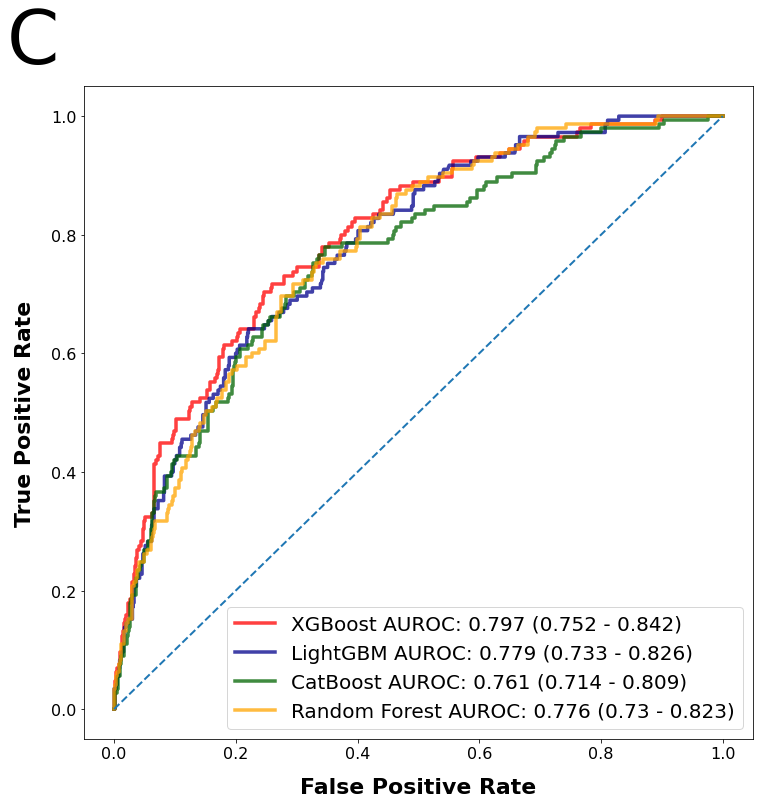

In [69]:
#Plot ROC curve.

f = pyplot.figure()
f.set_figwidth(12)
f.set_figheight(12)

xgb_fpr, xgb_tpr, _ = roc_curve(y_test, probs_xgb)
xgb_label = 'XGBoost AUROC: ' + xgb_auroc
pyplot.plot(xgb_fpr, xgb_tpr, label = xgb_label, color = 'red', linewidth = 3.5, alpha = 0.75)

lgb_fpr, lgb_tpr, _ = roc_curve(y_test, probs_lgb)
lgb_label = 'LightGBM AUROC: ' + lgb_auroc
pyplot.plot(lgb_fpr, lgb_tpr, label = lgb_label, color='darkblue', linewidth = 3.5, alpha = 0.75)

cb_fpr, cb_tpr, _ = roc_curve(y_test, probs_cb)
cb_label = 'CatBoost AUROC: ' + cb_auroc
pyplot.plot(cb_fpr, cb_tpr, label = cb_label, color = 'darkgreen', linewidth = 3.5, alpha = 0.75)

rf_fpr, rf_tpr, _ = roc_curve(y_test, probs_rf)
rf_label = 'Random Forest AUROC: ' + rf_auroc
pyplot.plot(rf_fpr, rf_tpr, label = rf_label, color = 'orange', linewidth = 3.5, alpha = 0.75)

pyplot.plot([0, 1], [0, 1], linestyle = '--', linewidth=2)

pyplot.title('C', x = -0.075, y = 1.005, fontsize = 75, pad = 20)
pyplot.xlabel('False Positive Rate', fontsize = 22, fontweight = 'heavy', labelpad = 16)
pyplot.ylabel('True Positive Rate', fontsize = 22, fontweight = 'heavy', labelpad = 16)
pyplot.tick_params(axis="y",direction="out", labelsize = 16)
pyplot.tick_params(axis="x",direction="out", labelsize = 16)

leg = pyplot.legend(loc = 'lower right', fontsize = 20)

pyplot.savefig('/content/drive/MyDrive/NTDB-Epidural/los_roc.png', dpi=300)
pyplot.show()

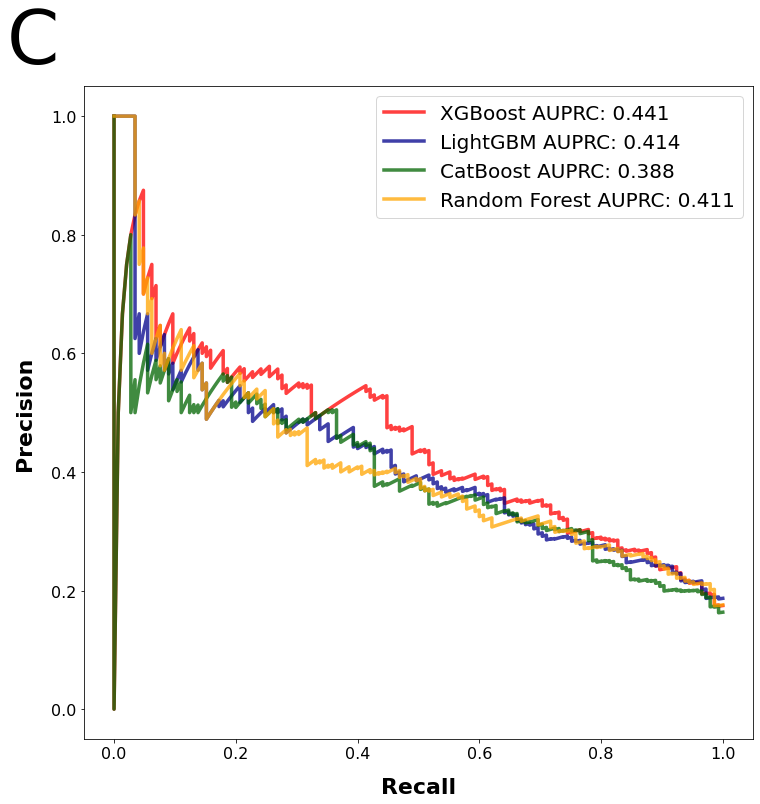

In [70]:
#Plot PR curve.

f = pyplot.figure()
f.set_figwidth(12)
f.set_figheight(12)

pyplot.plot(xgb_recall, xgb_precision, label='XGBoost AUPRC: {:.3f}'.format(xgb_auprc), color = 'red', linewidth = 3.5, alpha = 0.75)
pyplot.plot(lgb_recall, lgb_precision, label='LightGBM AUPRC: {:.3f}'.format(lgb_auprc), color = 'darkblue', linewidth = 3.5, alpha = 0.75)
pyplot.plot(cb_recall, cb_precision, label='CatBoost AUPRC: {:.3f}'.format(cb_auprc), color = 'darkgreen', linewidth = 3.5, alpha = 0.75)
pyplot.plot(rf_recall, rf_precision, label='Random Forest AUPRC: {:.3f}'.format(rf_auprc), color = 'orange', linewidth = 3.5, alpha = 0.75)


pyplot.title('C', x = -0.075, y = 1.005, fontsize = 75, pad = 20)
pyplot.xlabel('Recall', fontsize = 22, fontweight = 'heavy', labelpad = 16)
pyplot.ylabel('Precision', fontsize = 22, fontweight = 'heavy', labelpad = 16)
pyplot.tick_params(axis="y",direction="out", labelsize = 16)
pyplot.tick_params(axis="x",direction="out", labelsize = 16)

leg = pyplot.legend(loc = 'upper right', fontsize = 20)

pyplot.savefig('/content/drive/MyDrive/NTDB-Epidural/los_prc.png', dpi=300)
pyplot.show()

# Results Summary

In [71]:
results = {'XGBoost':xgb_results, 'LightGBM':lgb_results, 'CatBoost':cb_results, 'Random Forest':rf_results}

results = pd.DataFrame(results, columns = ['XGBoost', 'LightGBM', 'CatBoost', 'Random Forest'])

results

,XGBoost,LightGBM,CatBoost,Random Forest
0,0.448,0.593,0.352,0.559
1,0.516,0.368,0.505,0.36
2,0.48,0.454,0.415,0.438
3,0.844,0.772,0.841,0.77
4,0.39,0.334,0.333,0.313
5,0.797 (0.752 - 0.842),0.779 (0.733 - 0.826),0.761 (0.714 - 0.809),0.776 (0.73 - 0.823)
6,0.441,0.414,0.388,0.411


In [72]:
results = pd.DataFrame({'XGBoost':xgb_results, 'LightGBM':lgb_results, 'CatBoost':cb_results, 'Random Forest':rf_results})

results = results.T

results.columns = ['Precision', 'Recall', 'F1', 'Accuracy', 'MCC', 'AUROC (95% CI)', 'AUPRC']

results.to_csv('/content/drive/MyDrive/NTDB-Epidural/los_results.csv')

results

,Precision,Recall,F1,Accuracy,MCC,AUROC (95% CI),AUPRC
XGBoost,0.448,0.516,0.48,0.844,0.39,0.797 (0.752 - 0.842),0.441
LightGBM,0.593,0.368,0.454,0.772,0.334,0.779 (0.733 - 0.826),0.414
CatBoost,0.352,0.505,0.415,0.841,0.333,0.761 (0.714 - 0.809),0.388
Random Forest,0.559,0.36,0.438,0.77,0.313,0.776 (0.73 - 0.823),0.411


# SHAP Plots

In [73]:
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_yticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width, 
                                    break_long_words=break_long_words))
    ax.set_yticklabels(labels, rotation=0)

In [74]:
#Calculate SHAP values for XGBoost.

xgb_explainer = shap.Explainer(xgb.predict, x_test)
xgb_shap_values = xgb_explainer(x_test)

Permutation explainer: 907it [02:25,  6.00it/s]


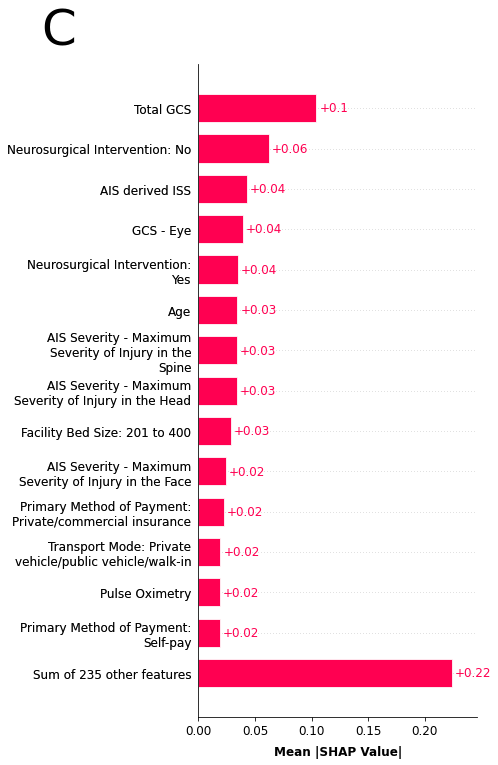

In [75]:
#Plot SHAP bar plot for XGBoost.

shap.plots.bar(xgb_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('C', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/NTDB-Epidural/los_shap_xgb.png', dpi=300, bbox_inches='tight')

In [76]:
#Calculate SHAP values for LightGBM.

lgb_explainer = shap.Explainer(lgb.predict, x_test)
lgb_shap_values = lgb_explainer(x_test)

Permutation explainer: 907it [02:42,  5.24it/s]


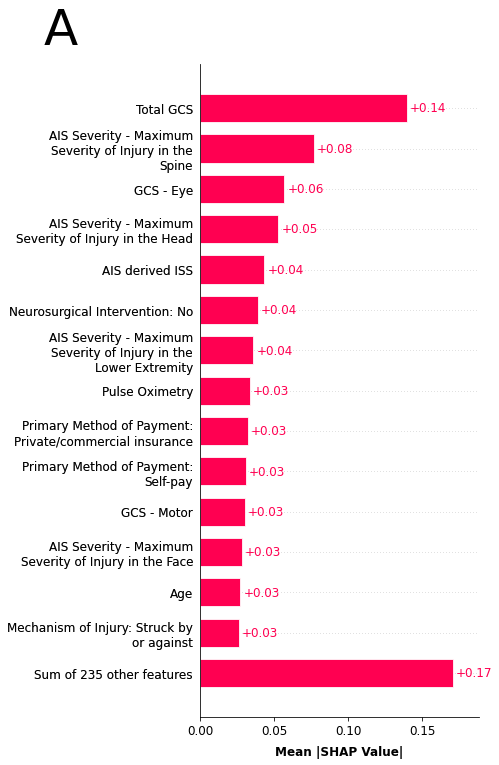

In [77]:
#Plot SHAP bar plot for LightGBM.

shap.plots.bar(lgb_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('A', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/NTDB-Epidural/los_shap_lgb.png', dpi=300, bbox_inches='tight')

In [78]:
#Calculate SHAP values for CatBoost.

cb_explainer = shap.Explainer(cb.predict, x_test)
cb_shap_values = cb_explainer(x_test)

Permutation explainer: 907it [04:28,  3.25it/s]


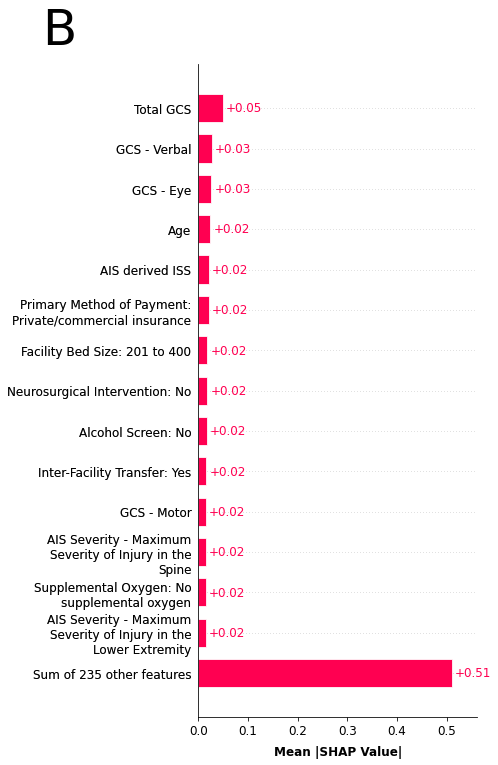

In [79]:
#Plot SHAP bar plot for CatBoost.

shap.plots.bar(cb_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('B', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/NTDB-Epidural/los_shap_cb.png', dpi=300, bbox_inches='tight')

In [80]:
#Calculate SHAP values for Random Forest.

rf_explainer = shap.Explainer(rf.predict, x_test)
rf_shap_values = rf_explainer(x_test)

Permutation explainer: 907it [18:54,  1.26s/it]


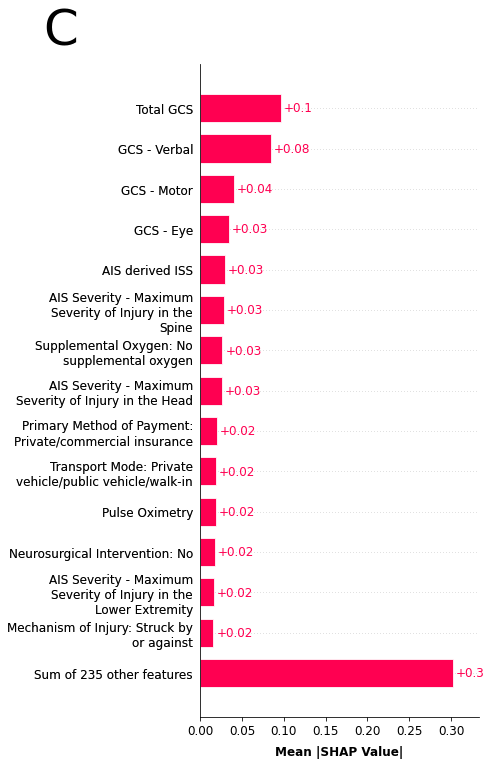

In [81]:
#Plot SHAP bar plot for Random Forest.

shap.plots.bar(rf_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('C', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/NTDB-Epidural/los_shap_rf.png', dpi=300, bbox_inches='tight')